In [342]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.metrics import f1_score

# Loading the Data

In [343]:
store_info = pd.read_csv("/kaggle/input/data-storm-4/Store-info.csv")
transactions=pd.read_csv("/kaggle/input/data-storm-4/Historical-transaction-data.csv")
testing = pd.read_csv("/kaggle/input/data-storm-4/Testing-data.csv")

# Basic Feature Engineering and Seperating Training and Testing

In [344]:
#dropping the ones that are not necessaary for this stage
transactions = transactions[['shop_id', 'item_price', 'quantity_sold']].copy()

#creating the income column 
transactions["income"] = transactions["item_price"]*transactions["quantity_sold"]
# transactions.head()

combined_data = store_info[['shop_id', 'shop_area_sq_ft']].copy()
combined_data['income']= combined_data["shop_id"].map(
    lambda key:transactions[transactions["shop_id"]==key]["income"].sum()
)
combined_data["quantity"]=combined_data["shop_id"].map(
    lambda key:transactions[transactions["shop_id"]==key]["quantity_sold"].sum()
)
combined_data = combined_data.rename(columns = {"shop_area_sq_ft":"area"})
combined_data["profile"] = store_info["shop_profile"].copy()
combined_data.head()

,shop_id,area,income,quantity,profile
0,SHOP047,528,842960,3288,Moderate
1,SHOP009,676,1970870,8411,High
2,SHOP083,676,1691985,6644,Low
3,SHOP117,676,2325980,8073,Low
4,SHOP042,676,1340215,5844,Low


In [345]:
# Seprating Training and Testing
training_data = combined_data[~combined_data["profile"].isnull()].copy()
testing_data = combined_data[combined_data["profile"].isnull()].copy()


In [346]:
#Remapping profiles to numbers
LOW = 0
MODERATE = 1
HIGH = 2
PREDICTION_CLASSES = [LOW,MODERATE,HIGH]
# Basic Feaure Names
ID = "shop_id"
PROFILE = "profile"
QUANTITY = "quantity"
INCOME = "income"
AREA = "area"
IP_TO_SP = {
    LOW:"Low",
    MODERATE:"Moderate",
    HIGH:"High"
}

SP_TO_IP = {value:key for key,value in IP_TO_SP.items()}
def iprofile_to_sprofile(iprofile:int):
    return IP_TO_SP[iprofile]
def sprofile_to_iprofile(sprofile:str):
    return SP_TO_IP[sprofile]

training_data['profile'] = training_data['profile'].map(sprofile_to_iprofile)
training_data.head()

,shop_id,area,income,quantity,profile
0,SHOP047,528,842960,3288,1
1,SHOP009,676,1970870,8411,2
2,SHOP083,676,1691985,6644,0
3,SHOP117,676,2325980,8073,0
4,SHOP042,676,1340215,5844,0


# Visual Analysis of Data

In [347]:
low_data = training_data[training_data[PROFILE]==LOW]
moderate_data = training_data[training_data[PROFILE]==MODERATE]
high_data = training_data[training_data[PROFILE]==HIGH]

## Low Data

<AxesSubplot:>

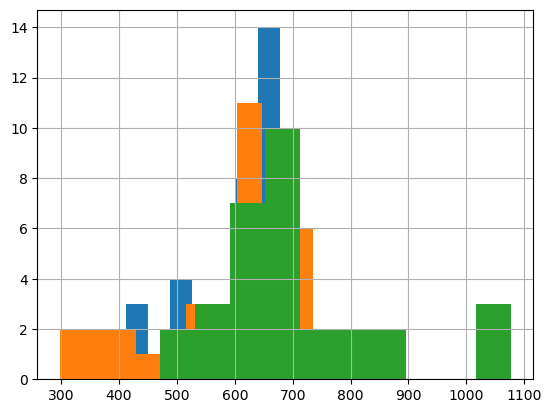

In [348]:
#area
feature = AREA
low_data[feature].hist()
# plt.show()
moderate_data[feature].hist()
# plt.show()
high_data[feature].hist()
# plt.show()

<AxesSubplot:>

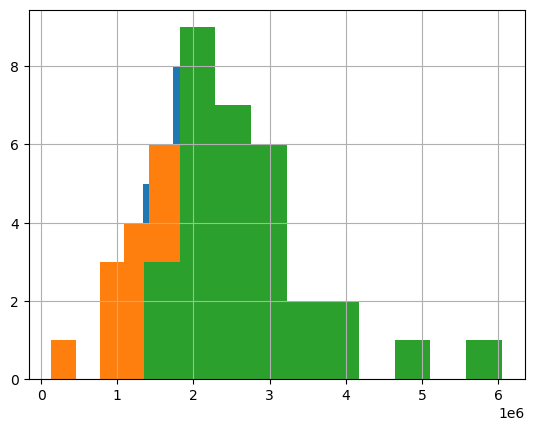

In [349]:
#income
feature = INCOME
low_data[feature].hist()
moderate_data[feature].hist()
high_data[feature].hist()

<AxesSubplot:>

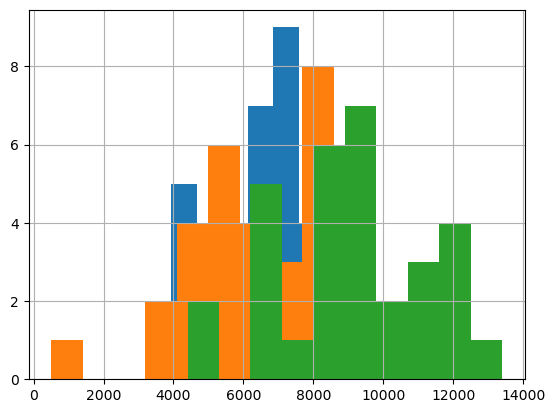

In [350]:
#income
feature = QUANTITY
low_data[feature].hist()
moderate_data[feature].hist()
high_data[feature].hist()

## Feature Vector Creation

In [351]:
def create_feature_vectors(df,features,prediction_name=None,normalization_parameters=None,normalize=True):
    #returns feature vector array and predictions if prediction_name is given
    df = df.copy() #creating a local copy
    #calculating normalization paramteres if they are not provided
    
    if(normalization_parameters is None):
        normalization_parameters = {feature:(df[feature].mean(),df[feature].std()) for feature in features}
    
    #normalizing according to the paramters
    if(normalize):
        for feature in features:
            mean,std = normalization_parameters[feature]
            df[feature] = (df[feature] - mean)/std
        
    feature_vectors = np.stack([df[feature].to_numpy() for feature in features],axis=1)
    if(prediction_name is None):
        return feature_vectors,normalization_parameters,None
    return feature_vectors,normalization_parameters,df[prediction_name].to_numpy()   

In [352]:
data = training_data
# data= training_data.head()
feature_vectors,normalization_parameters,ground_truth = create_feature_vectors(df=data,features=(AREA,INCOME,QUANTITY),prediction_name=PROFILE,normalize=True)

# Functions for evaluvations

In [353]:
def create_confusion_matrix(ground_truth,predictions,features):
    n_features = len(features)
    confusion_matrix = np.zeros((n_features,n_features))
    for index1,f1 in enumerate(features):
        for index2,f2 in enumerate(features):
            confusion_matrix[index1,index2] = np.sum((ground_truth == f1) & (predictions == f2))
    assert(len(predictions) == len(ground_truth) and len(predictions) == np.sum(confusion_matrix))
    return confusion_matrix/np.sum(confusion_matrix)
    

# Trying Out Basic Classification Methods

# Support Vector Machines

In [354]:
def try_out_svm(kernel):
    classifire = svm.SVC()
    classifire.fit(feature_vectors,ground_truth)
    predictions = classifire.predict(feature_vectors)
    confusion_matrix = create_confusion_matrix(ground_truth,predictions,[0,1,2])
    score = f1_score(y_true=ground_truth,y_pred=predictions,labels=PREDICTION_CLASSES,average='macro')
    return confusion_matrix,score,classifire

In [355]:
kernels = ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed']
best_svm = None
best_score = -1
for kernel in kernels:
    print(f"************Trying out kernel = {kernel}******************")
    cm,score,cla = try_out_svm(kernel)
    if(best_score < score):
        best_svm = cla
        best_score = score
    print(cm)
    print(f"f1 score:{score}")
    print(f"**********************************************************")

************Trying out kernel = linear******************
[[0.29 0.01 0.06]
 [0.16 0.11 0.06]
 [0.05 0.   0.26]]
f1 score:0.6389768939819497
**********************************************************
************Trying out kernel = poly******************
[[0.29 0.01 0.06]
 [0.16 0.11 0.06]
 [0.05 0.   0.26]]
f1 score:0.6389768939819497
**********************************************************
************Trying out kernel = rbf******************
[[0.29 0.01 0.06]
 [0.16 0.11 0.06]
 [0.05 0.   0.26]]
f1 score:0.6389768939819497
**********************************************************
************Trying out kernel = sigmoid******************
[[0.29 0.01 0.06]
 [0.16 0.11 0.06]
 [0.05 0.   0.26]]
f1 score:0.6389768939819497
**********************************************************
************Trying out kernel = precomputed******************
[[0.29 0.01 0.06]
 [0.16 0.11 0.06]
 [0.05 0.   0.26]]
f1 score:0.6389768939819497
**********************************************************


# Evaluvating the test data set

In [356]:
testing_data.head()

,shop_id,area,income,quantity,profile
100,SHOP046,545,2607865,6941,NaN
101,SHOP024,676,1308795,5274,NaN
102,SHOP023,617,2570425,7946,NaN
103,SHOP097,310,2642380,6934,NaN
104,SHOP044,715,1310440,4965,NaN


In [357]:
data = testing_data
# data= training_data.head()
test_feature_vectors,normalization_parameters,_ = create_feature_vectors(df=data,features=(AREA,INCOME,QUANTITY),prediction_name=None,normalize=True,normalization_parameters=normalization_parameters)
profile_predictions =best.predict(test_feature_vectors)
copy_testing = testing.copy()
copy_testing['shop_profile'] = list(map(iprofile_to_sprofile,profile_predictions,))
copy_testing

,shop_id,shop_profile
0,SHOP046,Moderate
1,SHOP024,Low
2,SHOP023,High
3,SHOP097,Moderate
4,SHOP044,Moderate
5,SHOP030,Moderate
6,SHOP038,Low
7,SHOP029,Low
8,SHOP096,High
9,SHOP092,Low


In [358]:
copy_testing.to_csv("/kaggle/working/svm_1_test_predictions_praveen.csv",index=False)